# (b) Pre-Processing and Exploratory data analysis

Import dependent packages then Split data points by their classes.

In [11]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


data = pd.read_csv(".\\data\\column_2C.dat", sep=' ', header=None)
f = data.values
f[:, 6][f[:, 6] == "AB"] = 1
f[:, 6][f[:, 6] == "NO"] = 0

class_0 = f[f[:, 6] == 0]
class_1 = f[f[:, 6] == 1]


Draw scatter plots.

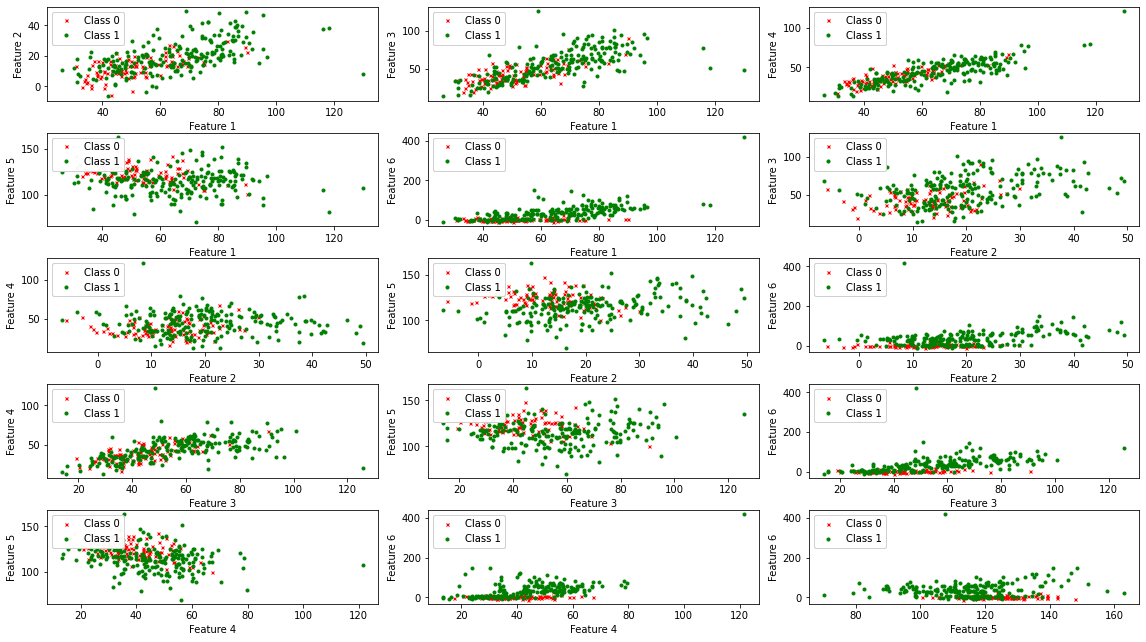

In [12]:
q = 1
plt.figure(figsize=(16, 9))
for i in range(0, 5):
    for j in range(i+1, 6):
        plt.subplot(5, 3, q)
        plt.xlabel("Feature %d" % (i+1))
        plt.ylabel("Feature %d" % (j+1))
        plt.plot(class_0[:, i], class_0[:, j], 'rx', ms=3)
        plt.plot(class_1[:, i], class_1[:, j], 'go', ms=3)
        l = plt.legend(('Class 0', 'Class 1'), loc=2)
        plt.gca().add_artist(l)
        q += 1
plt.tight_layout(pad=1, h_pad=0.1)
plt.show()


Draw box plots.

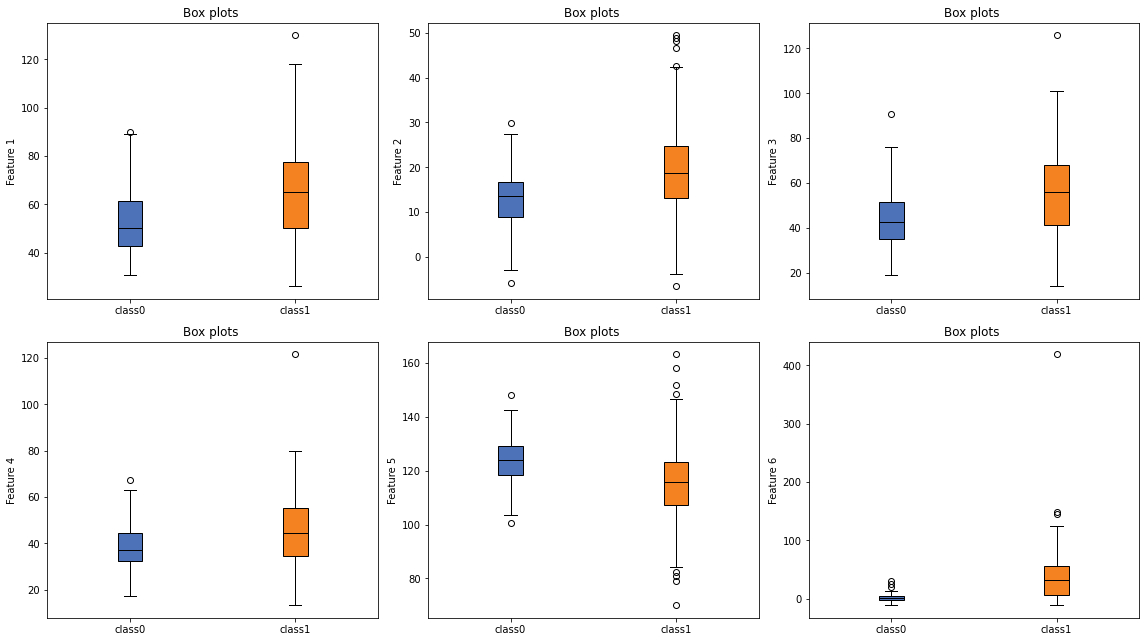

In [13]:
q = 1
plt.figure(figsize=(16, 9))
for i in range(0, 6):
    plt.subplot(2, 3, q)
    plt.ylabel("Feature %d" % (i+1))
    plt.title("Box plots ")
    bp = plt.boxplot([class_0[:, i], class_1[:, i]],
                     whis=1.5, medianprops={'color': 'black'}, patch_artist=True, labels=['class0', 'class1'])
    colors = ['#4e72b8', '#f58220']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    q += 1
plt.tight_layout(pad=1, h_pad=1)
plt.show()


Divide data points to training set and test set, then save them to .csv files for latter use.

In [14]:
train_f = np.zeros([210, 7])
test_f = np.zeros([len(f)-210, 7])
train_f[0: 140, :] = class_1[0: 140, :]
train_f[140:, :] = class_0[0: 70, :]
test_f[0: 70, :] = class_1[140:, :]
test_f[70:, :] = class_0[70:, :]
clf = preprocessing.StandardScaler()
train_features = clf.fit_transform(train_f[:, 0: 6])
# use same transform mareix as training
test_features = clf.transform(test_f[:, 0: 6])

train_data = np.column_stack((train_features, train_f[:, 6]))
test_data = np.column_stack((test_features, test_f[:, 6]))
with open(".\\src\\train.csv", 'w', newline='') as t_file:
    csv_writer = csv.writer(t_file)
    for l in train_data:
        csv_writer.writerow(l)

with open(".\\src\\test.csv", 'w', newline='') as t_file:
    csv_writer = csv.writer(t_file)
    for l in test_data:
        csv_writer.writerow(l)

# (c) Classification using KNN on Vertebral Column Data Set

Load the training and test data sets. For each k in given region, train the model and then test. Record the error rate with corresponding k. 

In [15]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

f = np.loadtxt(
    open(".\\src\\train.csv", "rb"), delimiter=",", skiprows=0)
train_data = f[:, :-1]
train_target = f[:, -1]
f = np.loadtxt(
    open(".\\src\\test.csv", "rb"), delimiter=",", skiprows=0)
test_data = f[:, :-1]
test_target = f[:, -1]

train_accuracy = np.zeros([70, 1])
test_accuracy = np.zeros([70, 1])
min_error = 1
best_n_neighbors = 0
for i in range(208, -2, -3):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_data, train_target)
    train_accuracy[int((208-i)/3)] = 1-clf.score(train_data, train_target)
    test_accuracy[int((208-i)/3)] = 1-clf.score(test_data, test_target)
    if test_accuracy[int((208-i)/3)] < min_error:
        max_clf = clf
        best_n_neighbors = i
        min_error = test_accuracy[int((208-i)/3)]

Plot the error rate in terms of k.

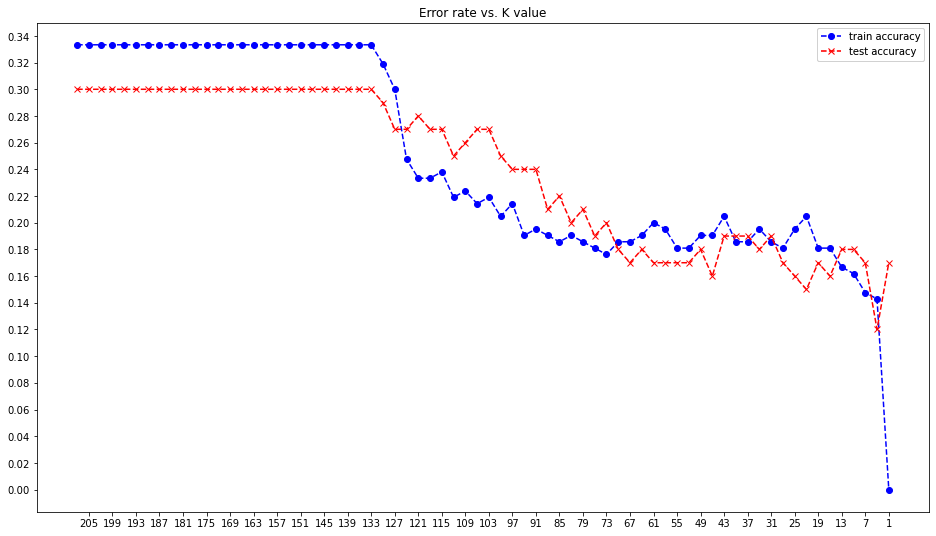

In [16]:
k = np.linspace(208, 1, 70)
plt.figure(figsize=(16, 9))
plt.plot(k, train_accuracy, 'b--', marker='o')
plt.plot(k, test_accuracy, 'r--', marker='x')
plt.title("Error rate vs. K value")
plt.xticks(k)
l = plt.legend(('train accuracy', 'test accuracy'), loc=1)
plt.gca().add_artist(l)
ax = plt.gca()
ax.invert_xaxis()
ax.locator_params(nbins=35)  # sparse the axis ticks

Calculate the confusion matrix, true positive rate, true negative rate, precision, and F-score.

In [17]:
print("Test KNN min error rate: %f n_neighbors= %f" %
      (min_error,  best_n_neighbors))
pred = max_clf.predict(test_data)
print('Confusion matrix')
print(confusion_matrix(test_target, pred))
tn, fp, fn, tp = confusion_matrix(test_target, pred).ravel()
print('True positive rate is %.2f' % (tp/tp+fn))
print('True negative rate is %.2f' % (tn/tn+fp))
print('True precision is %.2f' % (tp/(tp+fp)))
f1 = f1_score(test_target, pred, average='weighted')
print('F1-score %.2f' % f1)
plt.show()

Test KNN min error rate: 0.120000 n_neighbors= 4.000000
Confusion matrix
[[22  8]
 [ 4 66]]
True positive rate is 5.00
True negative rate is 9.00
True precision is 0.89
F1-score 0.88


## (iii) Draw Learning Curve.

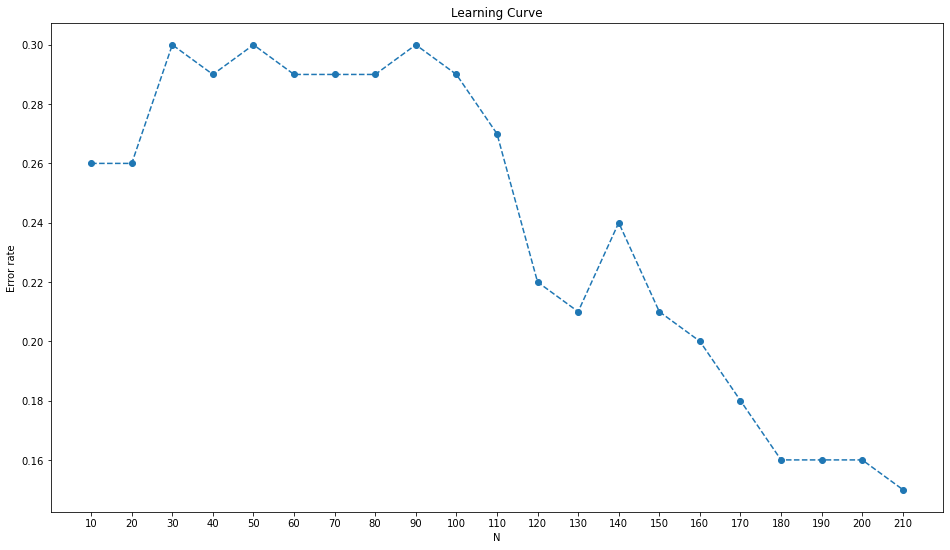

In [18]:
min_error_record = []
for N in range(10, 220, 10):
    sub_train_data = np.append(train_data[0:round(N-(N/3))],
                               train_data[140:(140+round(N/3))], axis=0)

    sub_train_target = np.append(train_target[0:round(N-(N/3))],
                                 train_target[140:(140+round(N/3))], axis=0)
    min_error = 1
    for i in range(1, N, 5):
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(sub_train_data, sub_train_target)
        test_accuracy = 1-clf.score(test_data, test_target)
        if test_accuracy < min_error:
            min_error = test_accuracy
    min_error_record.append(min_error)

k = range(10, 220, 10)
plt.figure(figsize=(16, 9))
plt.plot(k, min_error_record, '--', marker='o')
plt.xticks(k)
plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("Error rate")
plt.show()


# (d) Replace the Euclidean metric with the following metrics4 and test them. Summarize the test errors in a table.

Just choose different metric and p value when initializing KNN model. For every iteration, record the min error and relevent k value. 

In [19]:
min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(n_neighbors=i, metric='manhattan', p=1)
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Manhattan Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))

min_error = 1
best_p = 0
for i in range(1, 11, 1):
    clf = KNeighborsClassifier(
        n_neighbors=best_n_neighbors, p=10**(i/10))
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_p = i/10
print("Test KNN min error rate: %.4f lg(p)= %.4f" %
      (min_error,  best_p))

min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(n_neighbors=i, metric='chebyshev')
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Chebyshev Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))


min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(n_neighbors=i, metric='mahalanobis', algorithm='brute', metric_params={
        'V': np.cov(train_data)})
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Mahalanobis Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))


Test KNN using Manhattan Distance min error rate: 0.1400 best k=6
Test KNN min error rate: 0.1600 lg(p)= 0.4000
Test KNN using Chebyshev Distance min error rate: 0.1500 best k=1
Test KNN using Mahalanobis Distance min error rate: 0.1600 best k=6


| Metric | K value | Error rate |
| -----  | -----  | -----  |
| Euclidean | 4  | 0.12 |
| Manhattan | 6 | 0.14 |
| Chebyshev   | 1 | 0.15 |
| Mahalanobis  | 6 | 0.16 |


# (e) Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when $k\in\{1,6,11,...,196\}$.

In [20]:
min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(
        n_neighbors=i, metric='euclidean', weights='distance')
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Euclidean Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))

min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(
        n_neighbors=i, metric='manhattan', weights='distance')
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Manhattan Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))

min_error = 1
best_n_neighbors = 0
for i in range(1, 201, 5):
    clf = KNeighborsClassifier(
        n_neighbors=i, metric='chebyshev', weights='distance')
    clf.fit(train_data, train_target)
    test_accuracy = 1-clf.score(test_data, test_target)
    if test_accuracy < min_error:
        min_error = test_accuracy
        best_n_neighbors = i
print("Test KNN using Chebyshev Distance min error rate: %.4f best k=%d" %
      (min_error,  best_n_neighbors))


Test KNN using Euclidean Distance min error rate: 0.1500 best k=21
Test KNN using Manhattan Distance min error rate: 0.1500 best k=6
Test KNN using Chebyshev Distance min error rate: 0.1500 best k=1


# (f) What is the lowest training error rate you achieved in this homework?

The lowest training error rate occurs when using Euclidean metric, k=1, training error rate is 0.00